In [84]:
import numpy as np
from matplotlib import pyplot as plt

import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

import pymc3 as pm

# Gamma Ray Bursts

In the 1960's the US began the [Vela satellite program](https://en.wikipedia.org/wiki/Vela_(satellite)), sending gamma ray detectors into space with the intention of monitoring the USSR for secret nuclear tests violating the Nuclear Test Ban Treaty during the cold war (image credit:[Los Alamos National Laboratory](https://en.wikipedia.org/wiki/Vela_satellite#/media/File:Vela5b.jpg)).

<img src="https://imagine.gsfc.nasa.gov/Images/vela5b/vela5b_5.gif" width="250" alt="Vela"/>

These satellites picked up numerous bursts of gamma rays, but they were unlike anything seen during nuclear testing.

<img src="https://news.psu.edu/sites/default/files/styles/photo_gallery_large/public/Neutron_Star_Merger_Still_2.jpg" width="500" alt="GRB"/>

These bursts turned out to be cosmic, not terrestrial, in origin.  Know referred to as gamma ray bursts (GRBs), they are the brightest electromagnetic events known to happen in the universe (image credit:[NASA](https://fermi.gsfc.nasa.gov/)).

NASA's most recent mission to study these bursts is the Fermi Gamma Ray Space Telescope, which launched in 2008 (image credit:[NASA](https://www.nasa.gov/content/fermi/overview)).

<img src="https://www.nasa.gov/sites/default/files/fermi.jpg" alt="Fermi" width="500"/>

To date, Fermi has detected more than 2000 GRBs.  In this project we're going to look at its observations of these GRBs, particularly how long the bursts last, to develop a better understanding of what these GRBs are.

## Load Data

I've provided data downloaded directly from NASA's [Fermi GBM Burst Catalog](https://heasarc.gsfc.nasa.gov/W3Browse/fermi/fermigbrst.html).  There are lots more data available for these events, but we're going to focus on the distribution of `T90`, the time taken to accumulate 90% of the burst fluence starting at the 5% fluence level (fluence is the radiant energy received by a surface -- the gamma ray detectors in this case -- per unit area, with units $\mathrm{J}/\mathrm{m}^2$).

In [3]:
# Lets establish a data type.  We'll be storing event names and T90 measurements
dtype=[('event', 'S12'), ('T90', np.float64)]
data = np.genfromtxt('Fermi_GRBs.txt', usecols=(1,4), skip_header=5, delimiter='|', dtype=dtype)

print(data)
print("{} events read.".format(len(data)))

[(b'GRB140323433', 111.426) (b'GRB100325246',   8.192)
 (b'GRB100507577',  44.033) ... (b'GRB121117018', 331.782)
 (b'GRB160609690',   1.6  ) (b'GRB090222179',  17.408)]
2210 events read.


There is one burst without a `T90` measurement, so let's remove it from our dataset.

In [4]:
data = data[~np.isnan(data['T90'])]
print("{} events left.".format(len(data)))

2209 events left.


# Distribution of `T90`

Now let's take a look at the distribution of `T90`.

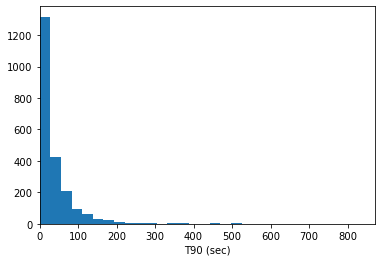

In [5]:
# Store T90 values in a dedicated array for convenience
T90 = data['T90']

plt.hist(T90, bins=30)

plt.xlabel('T90 (sec)')
plt.xlim(xmin=0);

It's hard to see any detail here, so let's use a log scale.

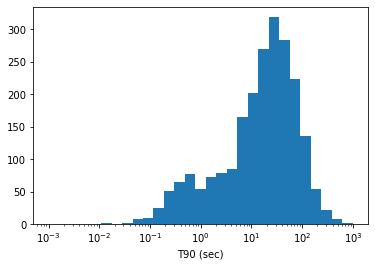

In [6]:
fig, ax = plt.subplots()

nbins = 30
bins = np.logspace(-3, 3, nbins)
plt.hist(data['T90'], bins=bins)
plt.xlabel('T90 (sec)')
ax.set_xscale('log');

This looks kind of Gaussian...ish.  Let's try modeling it with a normal distribution.

Since this is $\log_{10} (\mathrm{T90})$ we should technically be using a log-Normal distribution, but since we've already used standard Gaussian mixture models we'll just analyze the $\log$ of the data.

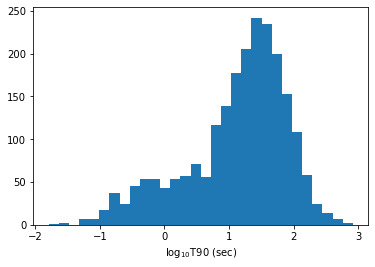

In [7]:
logT90 = np.log10(data['T90'])
plt.hist(logT90, bins=30)
plt.xlabel('$\log_{10}\mathrm{T90}$ (sec)');

# Results

Point totals for each section (481/581) are provided.

## Gaussian model (45/25)

Template Q1: Using the `logT90` dataset defined above, build a `PyMC3` Gaussian distribution model.  Describe each component of your model, describe the priors you use and why, identify which component is the likelihood.

In [35]:
# Gaussian model here (15/10)

with pm.Model() as gaussian_model:
    # priors for paramters of a gaussian distribution
    μ = pm.Normal('mean', mu= 0 , sd=10)
    σ = pm.HalfNormal('sd', sigma=10)
    # Now use these parameters to specify the likelihood
    T90_obs = pm.Normal('T90_obs', mu=μ, sd=σ, observed=logT90)

###### Discussion 1: Model Components, Priors, Likelihoods
Initially looking at the histogram for the logT90 data, we can see a gaussian shape with possibly a larger tail on the left side of the mean. For now, we'll just model this as a gaussian distribution of the log of time it took to accumulate 90% of the burst fluence. 

To set up this model, we first assign prior distributions to the parameters of our model. Gaussian distributions are characterized by their mean and standard deviation. For both of these paramters, we want to specify priors that don't restrict our posterior. From looking at the binned data you can see that there might be a mode of 1.5, but also the left side of the mode is considerably populated. I'm going to give the μ paramter's prior a mean of 0 and standard deviation of 5, and expect to see it float towards 1 or 1.5 in the marginal posterior distribution. As long as I let the gaussian_model sampler run long enough, we should avoide the danger of the μ prior pulling the posterior too close to zero. As for the prior on σ, the half normal distribution will give us positive-only values, and I'll give it a sd of 10 to keep the posterior from comitting to a too wide or too narrow concentration. 

Next I defined the likelihood as logT90, really the sampling distribution which takes in parameters μ, σ, and the real GRB data. 

The next two plots below are the prior distributions for the respective paramters:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mean]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 874.40it/s]


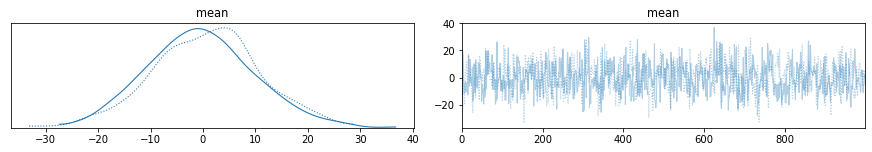

In [36]:
# Plotting the prior on μ
with pm.Model() as model:
    μ = pm.Normal('mean', mu= 0, sd=10)
    traceprior_μ = pm.sample(1000)
    pm.traceplot(traceprior_μ);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd]
Sampling chain 1, 1 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 772.70it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


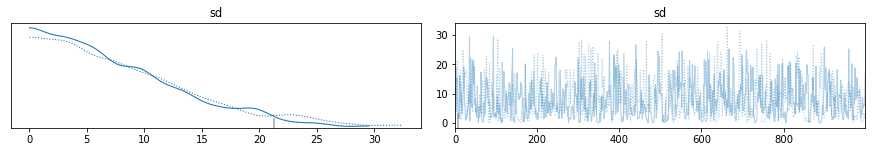

In [37]:
# Plotting the prior on σ 
with pm.Model() as model:
    σ = pm.HalfNormal('sd', sigma=10)
    traceprior_σ = pm.sample(1000)
    pm.traceplot(traceprior_σ);

Template Q2: Sample the posterior for this model.  Show your traces and discuss them.  Did you get good sampling?  Are you sure your priors aren't too restrictive?

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sd, mean]
Sampling chain 3, 0 divergences: 100%|██████████| 10500/10500 [00:20<00:00, 503.05it/s]
The acceptance probability does not match the target. It is 0.8874529709488804, but should be close to 0.8. Try to increase the number of tuning steps.


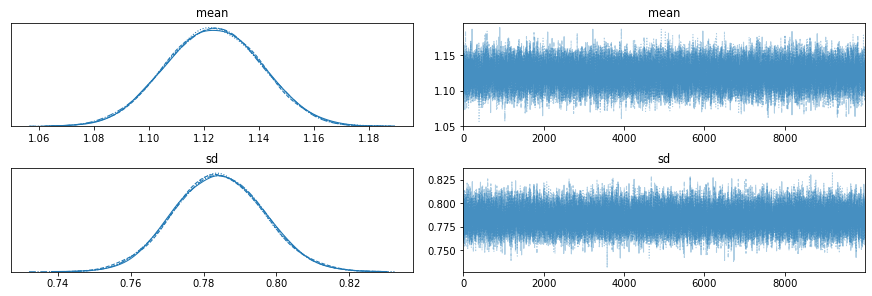

In [38]:
# Trace plots, etc. and discussion here (10/5)
with gaussian_model:
    #Usually I would have the sampler start at the MAP, but the pymc3 documentation reccomended not to if the 
    #mode of the distribution isn't representative of the full distribution, which is what I suspect.
    trace = pm.sample(10000, chains=4)

pm.traceplot(trace);

###### Discussion 2: Traces, sampling quality, prior influence

As stated in the cell above, I was cautious of having the sampler find the MAP first and start there. I didn't think that the mode was totally representative of the distribution, and pymc3 says that the MAP might amplify this bias. Looking at the traceplots, it doesn't look like the sampler accepted moves outside a very small range for both. Since I used rather broad priors, this is indicative of good sampling. We should consider if the sampler just got stuck at mu=1.13 and sd=0.79, and we didn't actually explore enough paramter space. I think that claim has little grounds, because looking at the original data, this is where we expected our mean to be. It incorporates the left side of the mode, which is pulling the mean lower than 1.5 (where I estimated the mean to be). The standard deviation also settled on a reasonable value. 


Template Q3: Show the marginal posterior estimates for the parameters in your model.  What have we learned?

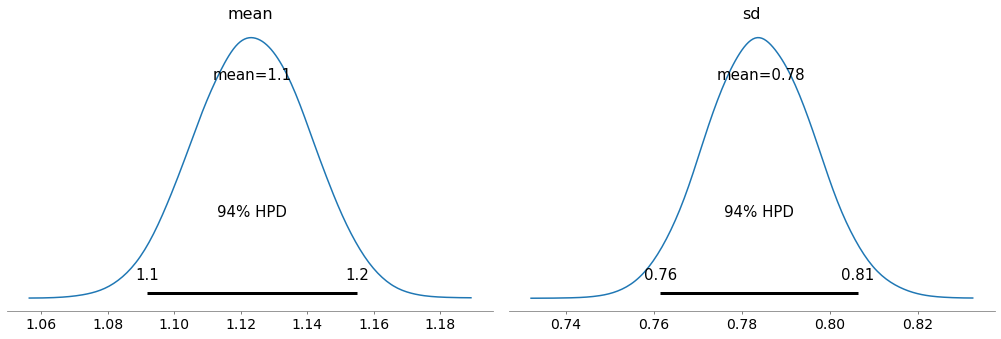

In [39]:
# Marginal posterior plots here (10/5)
pm.plot_posterior(trace, var_names=['mean', 'sd']);

###### Discussion 3: marginal posteriors and what they mean

Here we have the marginal posterior distributions of the parameters we're using to fit our data. The method we're using so far estimates that the distribution of the log of time (it takes to accumulate 90% of the burst fluence) follows a gaussian distribution with a mean of 1.1 and a standard deviation of 0.78. 

Template Q4: How well does your model fit the data?  You can show this by either plotting the posterior constraints for your model with the data, or doing posterior predictive checks and simulating data from your constrained model and comparing to the actual data.

In [41]:
# Compare to data here (10/5)
with gaussian_model:
    ppc_trace = pm.sample_posterior_predictive(trace, 5000)

/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 5000/5000 [00:17<00:00, 281.66it/s]


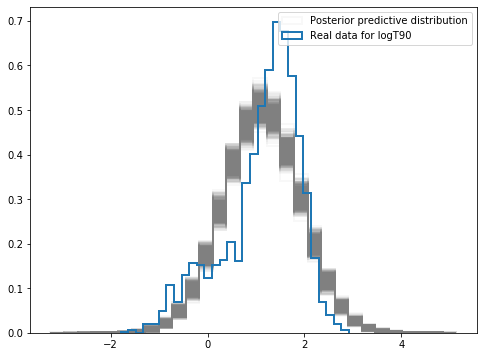

In [46]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(ppc_trace['T90_obs'], bins=30, density=True,
        histtype='step', lw=2,
        color=['.5'] * ppc_trace['T90_obs'].shape[1],
        alpha=.05,
        label='Posterior predictive distribution');
ax.hist(logT90, bins=30, density=True,
        histtype='step', lw=2,
        label='Real data for logT90');
ax.legend(loc=1);

In [47]:
np.asarray(ppc_trace['T90_obs']).shape

(5000, 2209)

###### Discussion 4: Posterior Predictive Check

Using the PPC function "pm.sample_posterior_predictive"  I drew 5000 samples from the posterior, each sample containing 2209 predicted events. When we did this in class during week 5 we just took one sample, but I noticed Austin Rochford's example here: https://docs.pymc.io/notebooks/posterior_predictive.html where they came up with a nice graphing method to show a great deal of samples. 

So clearly something outside of our model is going on here. Simply using one gaussian characteristic fails to realize the mode because the data is pulled down and to the left by the populated bins from about -1 to 1.  

<font color='red'>Great work. I like this way of visualizing the PPC. Additionally, it's nice to have matched binning for a very direct comparison, and you can also add CIs and the best fit for more info. 9/10</font>


## Gaussian mixture model (55/55)

Template Q5: Now lets use a 2-component Gaussian mixture model to better understand the data. Build a 2-component *marginalized* Gaussian mixture model (i.e., no latent categorical variables). Describe each component of your model, describe the priors you use and why, identify which component is the likelihood.

In [8]:
# Gaussian mixture model here (15/15)
#The prompt says to use 2 components in the Dirichlet distribution
components = 2
with pm.Model() as mixture_model:
    weights = pm.Dirichlet('weights', np.ones(components))
    mu = pm.Normal('mu', 0., 10., shape=components)
    tau = pm.Gamma('tau', 1., 1., shape=components)
    logT90_obs = pm.NormalMixture('logT90_obs', weights, mu, tau=tau, observed=logT90)

###### Discussion 5: 

This model takes a finite number of gaussian distributions to apply to the data. Since the question specified 2 components, the first line of code declares this but I can also change that later. The two underlying phenomena we're observing will likely have different sway on the data, and we want let our sampling track this. We initialize this by giving it a Dirichlet distribution with each component having equal weight. The next prior we specify is the means of each component, to which I gave each the same parameters (mu=0,sd=10) as the first model.

The normal-mixture documentation in pymc3 said that I only have to pass in sigma or tau, but not both. So I decided to use tau as a parameter describing the precision of the components because I knew the alpha/beta parameterization of the gamma distribution would be a broad prior if I set them both equal to one. Finally the likelihood of observing logT90 times is defined using the normal-mixture distribution. It handles the weights, means, and precision of the prior distributions as well as the actual data. 

Template Q6: Sample the posterior for this model.  Show your traces and discuss them.  Did you get good sampling?  Are you sure your priors aren't too restrictive?

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [tau, mu, weights]
Sampling chain 3, 0 divergences: 100%|██████████| 5500/5500 [01:13<00:00, 74.82it/s]
The acceptance probability does not match the target. It is 0.8797589174024033, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


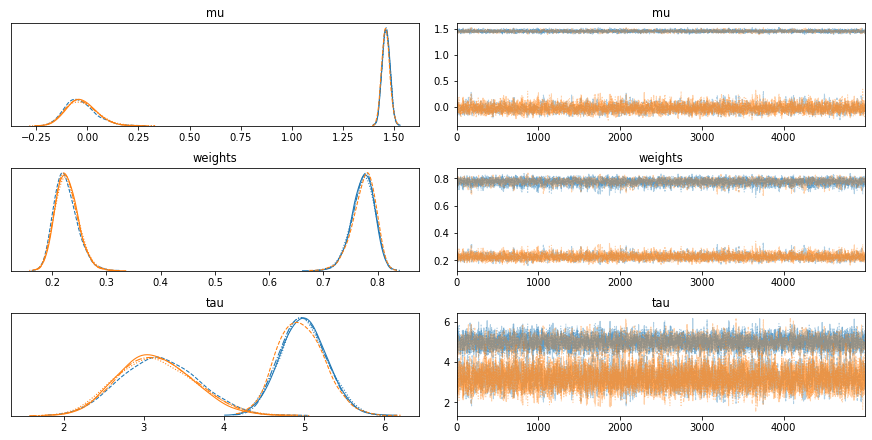

In [9]:
# Trace plots and discussion here (10/10)
with mixture_model:
    trace_mixture = pm.sample(5000, chains=4)

pm.traceplot(trace_mixture);

###### Discussion 6: Traceplots, sampling quality, priors

The traceplots look good. With the simple gaussian model we estimated mu=1.1, but now with the mixing distributions you can see how that was just an effect of the two mu values (top right graph) becoming muddles together. Again, with very general and noncommitting priors, it is safe to say that we haven't restricted the posterior to take the two paths shown. Not only was each gaussian component was given the same prior distribution, but each chain that the NUTS sampler ran matched up well with eachother.  

The new parameter we introduced as the weights has also found two definitive points. The new paramter I introduced in lieu of standard deviation, tau, gives an indication of how tightly packed the sampling was. 

Template Q7: Show the marginal posterior estimates for the parameters in your model.  What have we learned?

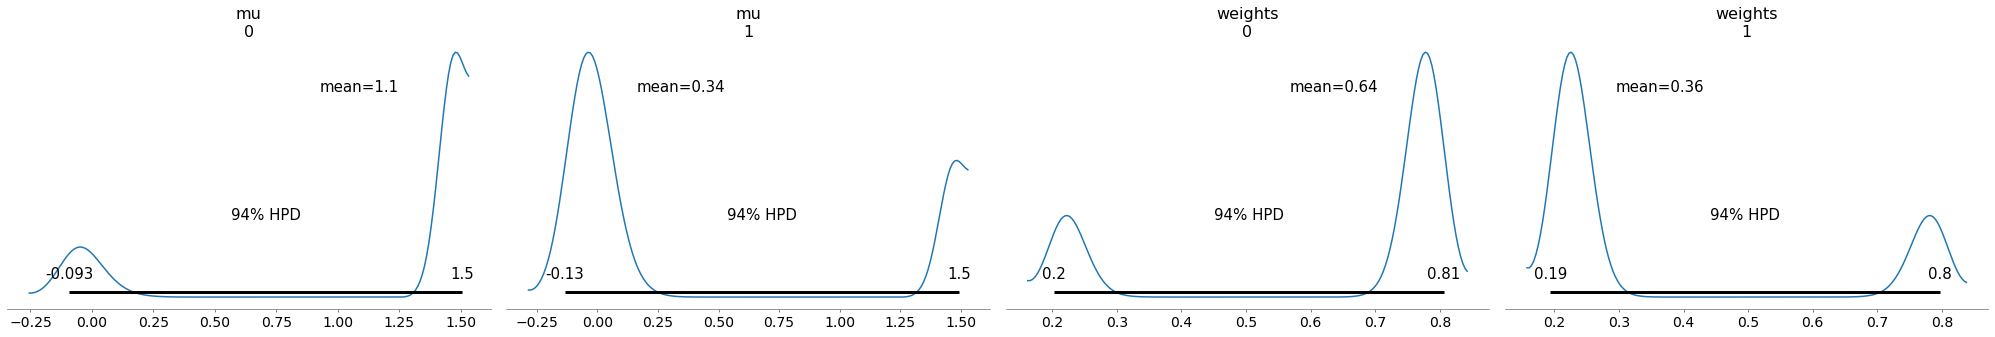

In [12]:
# Marginal posterior plots here (10/10)
pm.plot_posterior(trace_mixture, var_names=['mu', 'weights']);

###### Discussion 7:  Marginal posterior plots

Looking at the posteriors for the weights, it seems like the majority of the data is coming from the 0th component, because the probability density is peaked around 0.75. Even though the graph displays the average of the distribution as 0.64, I don't think that means much now that we're looking at are more complex distribution. The other component at work is most likely to be accounting for the remaining 25% of the posterior. The plots also reveal that there is a small chance that this allocation of weights is reversed, hence the small bump on the opposite end of the axis. 

For the "mu" parameter, the 0th component has a large probability of being centered on 1.5 (as we eyeballed from the real data histogram), and the other component centered on 0. There's also the case where these probabilities are reversed, corresponding to the less likely weight allocation. Thinking about this in terms of two gaussian distributions overlapped, we should feel like we're on the right track in order to match up with the real dataset.

Template Q8: How well does your model fit the data.  You can show this by either plotting the posterior constraints for your model with the data, or doing posterior predictive checks and simulating data from your constrained model and comparing to the actual data.  How is your Gaussian mixture model performing compared to single Gaussian model above?

In [15]:
# Compare to data here (10/10)
with mixture_model:
    ppc_trace_mixture = pm.sample_posterior_predictive(trace_mixture, 1000)

100%|██████████| 1000/1000 [04:31<00:00,  3.69it/s]


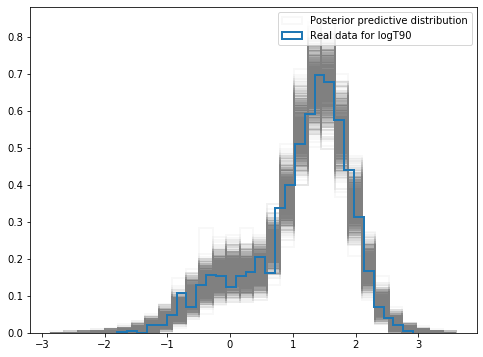

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(ppc_trace_mixture['logT90_obs'], bins=30, density=True,
        histtype='step', lw=2,
        color=['.5'] * ppc_trace_mixture['logT90_obs'].shape[1],
        alpha=.05,
        label='Posterior predictive distribution');
ax.hist(logT90, bins=30, density=True,
        histtype='step', lw=2,
        label='Real data for logT90');
ax.legend(loc=1);

###### Discussion 8: Posterior Predictive Check

The mixture model works much better. While there is a fair amount of scattering, you can definitely see the shape of the real histogrammed data in the posterior. The only potentially concerning thing I see is that the tails of the posterior have nonzero support out pretty far past the real data. The real data terminates before the -2 tickmark, but the posterior nearly reaches -3. Since we're looking at time on a logarithmic scale, this is a considerable difference. Same goes for the +3 side, where the model predicts the possibility of very long T90 times. However, the probability density out in those concerning regions is practically zero, so we can still have a good amount of confidence in the model.
<font color='red'>This looks great.</font>

Template Q9: The two subpopulations you have constrained here are thought to arise from very different processes.  The short-duration population, creatively named *short gamma ray bursts*, are believed to be from compact binary mergers with neutron stars (GW170817/GRB170817A is the first confirmation of this).  The *long gamma ray bursts* are instead the death of massive stars, and are often associated with core-collapse supernovae.

From your posterior estimates above, what can you say about the fraction of detected GRBs that are short GRBs?

In [59]:
# Posterior estimate for detected fraction of short GRBs (5/5)
print('If we were to take the marginal posterior mean at face value:')
print("{} from short gamma ray bursts.".format(trace_mixture['weights'][:,1].mean()))
print("{} from long gamma ray bursts.".format(trace_mixture['weights'][:,0].mean()))

If we were to take the marginal posterior mean at face value:
0.364080652863474 from short gamma ray bursts.
0.635919347136526 from long gamma ray bursts.


In [62]:
from scipy import stats
print(stats.mode(trace_mixture['weights'][:,1]))
print(stats.mode(trace_mixture['weights'][:,0]))

ModeResult(mode=array([0.21198819]), count=array([4]))
ModeResult(mode=array([0.77463632]), count=array([4]))


###### Discussion 9:

The marginal posterior for the weights is normalized to a percent value, and the mean of each distribution would indicate 36% short bursts and 64% long bursts. However, I think these mean values are sort of arbitrary because the distributions are weighed down by the possibility of component 0 being responsible for the short GRBs. A better guess would be to use the modes of the distributions, where the short bursts are about 21% of the data and long bursts account for the rest. <font color='red'>actually best to use the categorical model for this part too... -2</font>

Template Q10: Finally, lets determine the class of some specific GRBs.  For this you will need to build a new model with latent variables for the subpopulation type of each GRB.

What is the most likely GRB type for `GRB110717180`?  How certain is this association?  What about `GRB080808451`?

In [79]:
# Posterior estimates for associations of specific GRBs (5/5)
components = 2
with pm.Model() as model:
    # define the hyperparameters
    w = pm.Dirichlet('weight', a=np.ones(components), shape=components, testval=np.ones(components)/components)

    μ = pm.Normal('mu', 0., 10., shape=components, testval=np.linspace(.2, .8, 2))
    σ = pm.HalfNormal('sd', sigma=10, shape=components)
    
    # Reject proposals to swap the ordering of the factory modes
    switch = pm.math.switch(μ[1] - μ[0] < 0, -np.inf, 0)
    order_mode_potential = pm.Potential('order_mode_potential', switch)

    # latent subpopulation association of each observation
    burst_type = pm.Categorical('burst_type', p=w, shape=len(logT90))
    
    variable_mu = μ[burst_type]
    variable_sd = σ[burst_type]
    
    # define the likelihood
    T90_obs = pm.Normal('T90_obs', mu=variable_mu, sd=variable_sd, observed=logT90)

In [82]:
with model:
    trace = pm.sample(1000)

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [sd, mu, weight]
>BinaryGibbsMetropolis: [burst_type]
Sampling chain 1, 999 divergences: 100%|██████████| 1500/1500 [3:25:58<00:00,  8.24s/it]    
The acceptance probability does not match the target. It is 0.9577167275638411, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1495 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3852866910255365, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f11faa3cf10>,
      dtype=object)

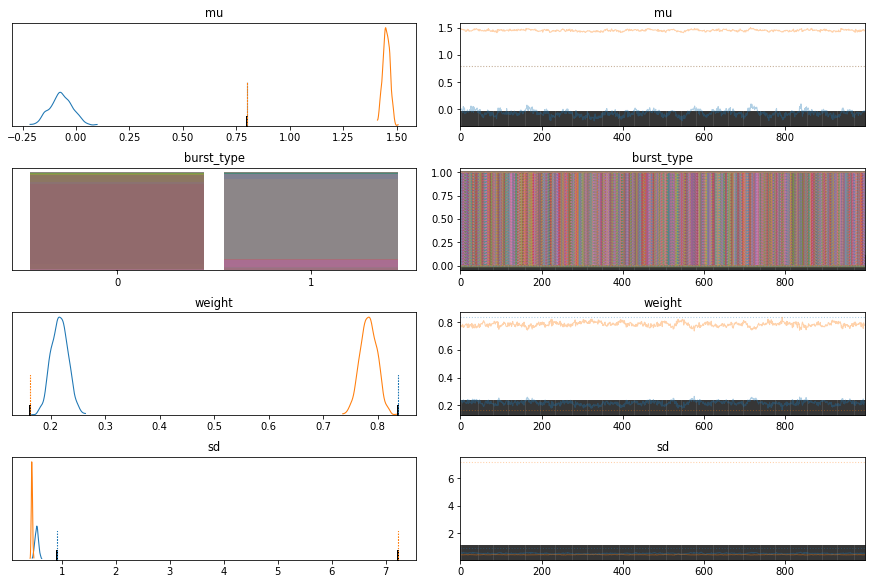

In [83]:
pm.traceplot(trace)

<font color='red'>You're allready most of the way there, since the categorical model works. However You will also need to find those specific events by name, and then look at their samples for category. 2/5.

Overall, great work. (94/100)</font>

## 581 students: Just 2 components? (0/20)

Is a two-component model the best descriptor of the data?  Convince me.

In [78]:
len(logT90)

2209